In [94]:
import numpy as np
import matplotlib.pyplot as plt

In [95]:
namesngenre = np.load('./dataset/namesngenre.npy')

In [96]:
namesngenre

array([['Toy Story (1995)',
        'Adventure|Animation|Children|Comedy|Fantasy'],
       ['Jumanji (1995)', 'Adventure|Children|Fantasy'],
       ['Grumpier Old Men (1995)', 'Comedy|Romance'],
       ...,
       ['Elsa & Fred (2005)', 'Comedy|Drama|Romance'],
       ['Tomb Raider (2018)', 'Action|Adventure|Fantasy'],
       ['Fred Armisen: Standup for Drummers (2018)', 'Comedy']],
      dtype='<U158')

In [97]:
ratings_train = np.load('./dataset/ratings_train.npy')

In [98]:
ratings_train.shape

(610, 4980)

In [99]:
ratings_train

array([[ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan,  2., nan, ..., nan, nan, nan],
       [ 3., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [100]:
np.nanmax(ratings_train)

5.0

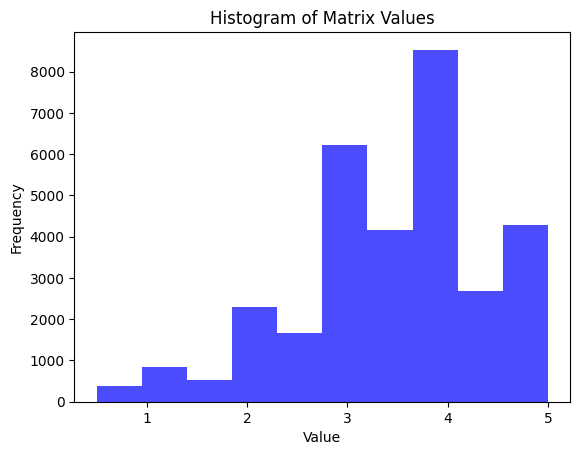

In [101]:
from scipy.stats import norm, fit
# Flatten the matrix to a 1D array to create the histogram
values = ratings_train.flatten()
values = values[~np.isnan(values)]
# Fit a normal distribution to the histogram
mu, std = norm.fit(values)

# Set the number of bins for the histogram
num_bins = 20

# Create the histogram plot
plt.hist(values, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Matrix Values')

# Show the histogram
plt.show()

Mean (mu): 3.524605987720742
Standard Deviation (sigma): 1.0326053351746378


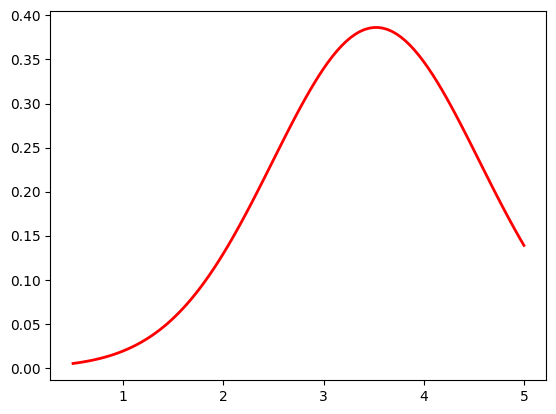

In [102]:
# Create the x-axis values for the normal distribution curve
x = np.linspace(min(values), max(values), 100)
pdf = norm.pdf(x, mu, std)

# Plot the histogram
plt.plot(x, pdf, 'r-', linewidth=2)

# Print the parameters of the best-fit normal distribution
print(f"Mean (mu): {mu}")
print(f"Standard Deviation (sigma): {std}")

# Product of two gaussians

Our R matrix will be the result of the product of two other matrices. In order to have a good initialization of these two matrices, we may assume that R follows the gaussian distribution below, and initialize our matrices I and U using gaussian distribitutions that result in the gaussian above.

$$ R = IU^T $$

$$ E(R) = \mu_I \cdot \mu_U $$

\begin{align*}
\text{Var}(R) &= (\sigma_I^2 + \mu_I^2) \cdot (\sigma_U^2 + \mu_U^2) - (\mu_I \cdot \mu_U)^2 \\
              &= \sigma_I^2 \cdot \sigma_U^2 + \sigma_I^2 \cdot \mu_U^2 + \mu_I^2 \cdot \sigma_U^2 + \mu_I^2 \cdot \mu_U^2 - (\mu_I \cdot \mu_U)^2
\end{align*}

We can take U and I with equal distributions, so we have:

$$ E(R) = \mu \cdot \mu  = \mu^2$$

\begin{align*}
\text{Var}(R) &= (\sigma^2 + \mu^2) \cdot (\sigma^2 + \mu^2) - (\mu \cdot \mu)^2 \\
              &= \sigma^2 \cdot \sigma^2 + \sigma^2 \cdot \mu^2 + \mu^2 \cdot \sigma^2 + \mu^2 \cdot \mu^2 - (\mu \cdot \mu)^2
              &= \sigma^4 + 2 \cdot \mu^2 \cdot \sigma^2
\end{align*}

In [103]:
mu_UI = mu**0.5
mu_UI

1.8773934024920673

In [104]:
from scipy.optimize import fsolve

# Define the equation
def equation(sigma, var_R, mu_UI):
    return sigma**4 + 2 * mu_UI**2 * sigma**2 - var_R

# Define the known values
var_R = std**2

initial_guess = 1.0
sigma = fsolve(equation, initial_guess, args=(var_R, mu_UI))[0]

print("The value of sigma is:", sigma)

The value of sigma is: 0.38489986190541


The values calculated above are going to be used in the U and I matrix initialization (recalculated in the MF class).

In [129]:
import MF
import importlib

# Reload a specific module
importlib.reload(MF)

<module 'MF' from 'c:\\Users\\User\\Documents\\Estudos\\M2 Dauphine\\Data Science Lab\\collaborative_filter\\MF.py'>

In [130]:
k = 100

MF = MF.MatrixFactorizarion(ratings_train, l=0.001, mu=0.001, k=k)


In [131]:
print(MF.C(MF.R, MF.I, MF.U, l=0.001, mu=0.001))

378028161695.90985


In [132]:
MF.fit(lr_I=0.000001, lr_U=0.000001, num_iterations=100)

Iteration 1: Cost = 772064631519.9376
Iteration 2: Cost = 42990901896.39163
Iteration 3: Cost = 212645523113.3507
Iteration 4: Cost = 442007676826.39526
Iteration 5: Cost = 2676265910.3043647
Iteration 6: Cost = 1085701880.9428146
Iteration 7: Cost = 488275900.05864745
Iteration 8: Cost = 230352355.5189067
Iteration 9: Cost = 112424159.34739146
Iteration 10: Cost = 57089651.8975722
Iteration 11: Cost = 30805706.69160452
Iteration 12: Cost = 18243885.993434664
Iteration 13: Cost = 12218250.846922165
Iteration 14: Cost = 9318442.746046776
Iteration 15: Cost = 7916388.63266801
Iteration 16: Cost = 7232666.834007623
Iteration 17: Cost = 6893634.534434848
Iteration 18: Cost = 6720057.763495601
Iteration 19: Cost = 6625932.765334292
Iteration 20: Cost = 6569985.340345637
Iteration 21: Cost = 6532406.051658166
Iteration 22: Cost = 6503686.993635599
Iteration 23: Cost = 6479264.485476483
Iteration 24: Cost = 6456947.882459532
Iteration 25: Cost = 6435685.517266437
Iteration 26: Cost = 6414972.

In [133]:
prediction_full = MF.predict()

## Result analysis

__Attention:__ Here we pick only the non nan values, which returns a 1-D array. Then we reshape a part of them so we can see it as a image and visually comapre the results.

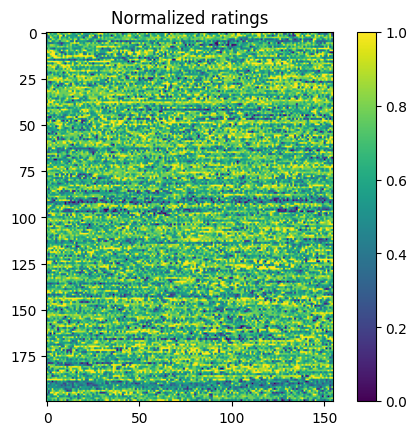

In [134]:
non_nan_indices = np.where(~np.isnan(ratings_train))
# Separate the row and column indices
row_indices, col_indices = non_nan_indices
R_non_nan = MF.R[row_indices, col_indices]
normalized_ratings = (R_non_nan - np.min(R_non_nan)) / (np.max(R_non_nan) - np.min(R_non_nan))
normalized_ratings = normalized_ratings[:normalized_ratings.shape[0]//1000 * 1000].reshape(200, -1)

# Create a heatmap using a colormap (e.g., 'viridis')
plt.imshow(normalized_ratings, cmap='viridis')
plt.colorbar()  # Add a colorbar for reference

# Show the heatmap
plt.title('Normalized ratings')
plt.show()


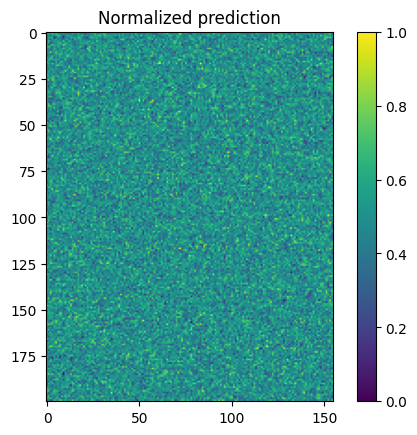

In [135]:
# Separate the row and column indices
row_indices, col_indices = non_nan_indices

# Access the corresponding values in the second matrix
prediction = prediction_full[row_indices, col_indices]
normalized_prediction = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))
normalized_prediction = normalized_prediction[:normalized_prediction.shape[0]//1000 * 1000].reshape(200, -1)
# Create a heatmap using a colormap (e.g., 'viridis')
plt.imshow(normalized_prediction, cmap='viridis')
plt.colorbar()  # Add a colorbar for reference

# Show the heatmap
plt.title('Normalized prediction')
plt.show()